In [1]:
#Instalacaicón de paquetes
!pip install spacepy
!pip install cdflib
!pip install matplotlib

In [2]:
#Instalación de librerías
import cdflib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
#dmsp-f16_ssm_magnetometer_20130601_v1.0.4.cdf
![Binder](https://mybinder.org/badge_logo.svg)(https://mybinder.org/v2/gh/lkilcommons/OvationPyme/HEAD?labpath=notebooks%2FInteractiveWithHemisphericPower.ipynb) #Binder para ejecutar el código en línea en un servidor de Jupyter Notebook en la nube de forma gratuita sin necesidad de instalar nada en tu computadora local y sin necesidad de registrarte en ningún sitio web ni de proporcionar ningún tipo de información personal o de pago en línea para ejecutar el código en línea en un servidor de Jupyter Notebook en la nube de forma gratuita sin necesidad de instalar nada en tu computadora local y sin necesidad de registrarte en ningún sitio web ni de proporcionar ningún tipo de información personal o de pago en línea

"[Binder]" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Procesando archivo: f16.1
Archivo cargado: dmsp-f16_ssjs_precipitating-electrons-ions_20141231000000_20141231235959_cdaweb.cdf


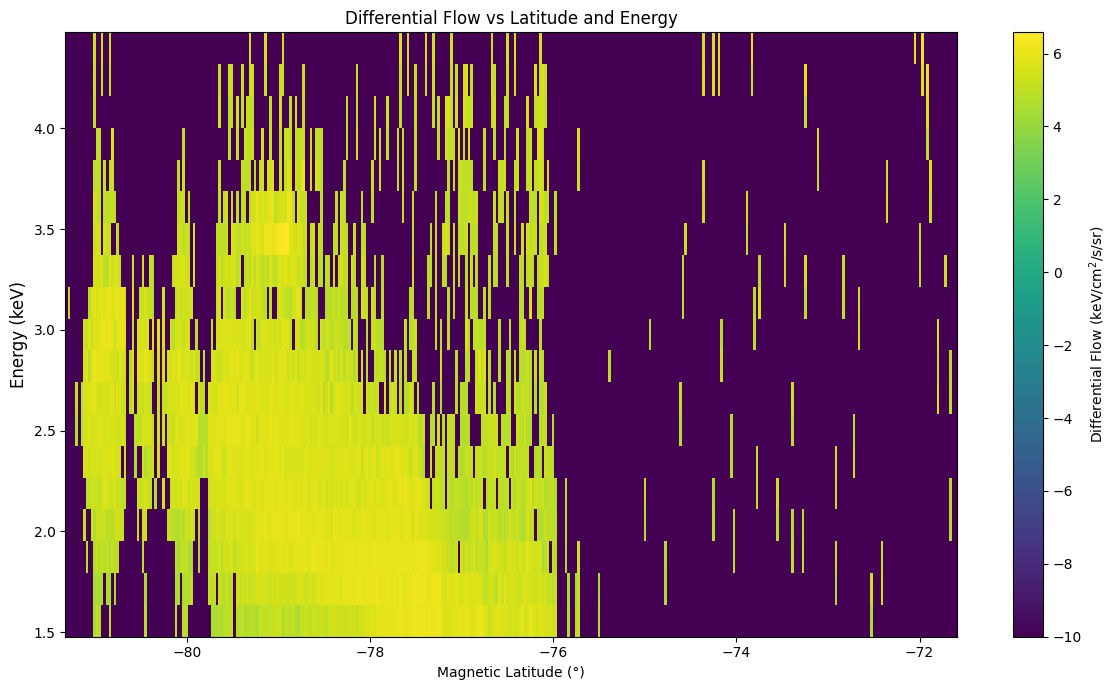

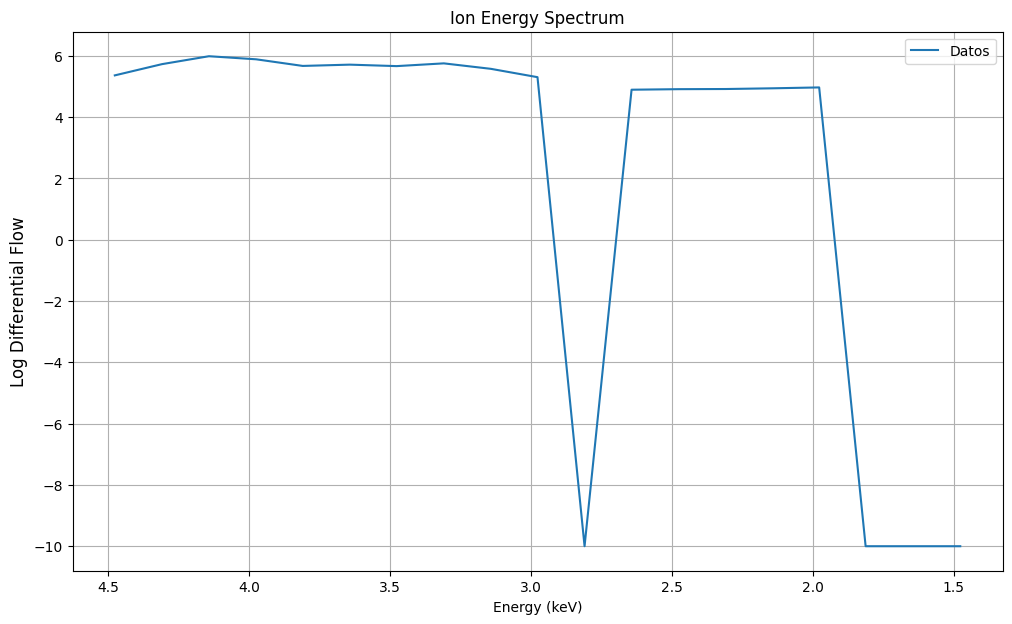

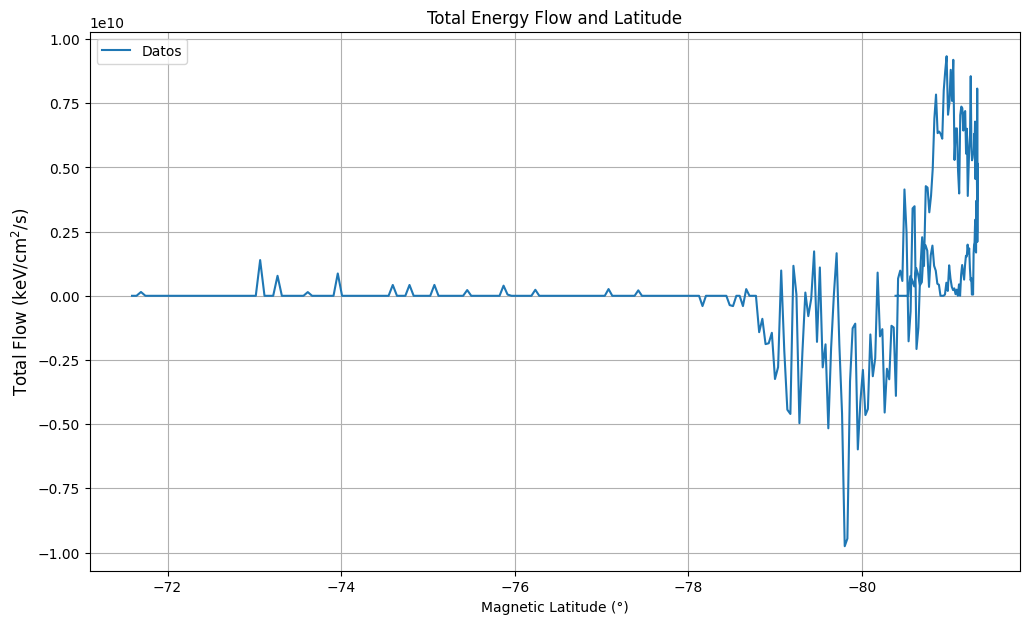

b2i se encuentra en la latitud magnética -80.976° y en el tiempo 2014-12-31T22:03:34.000000000
Procesando archivo: f16.2
Archivo cargado: dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf


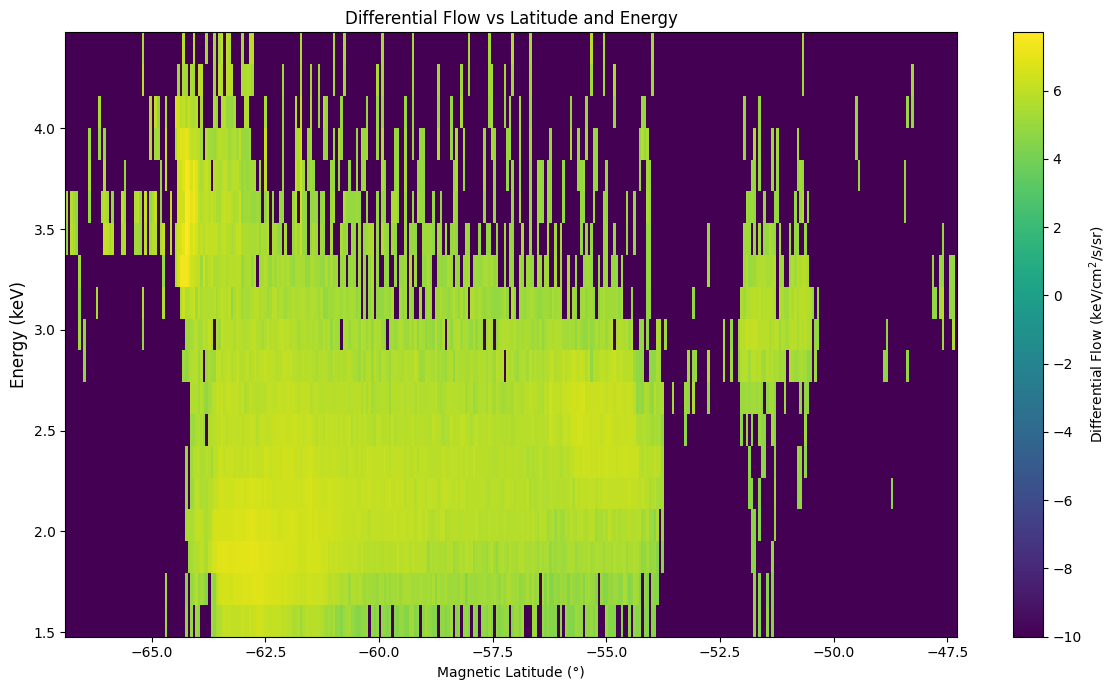

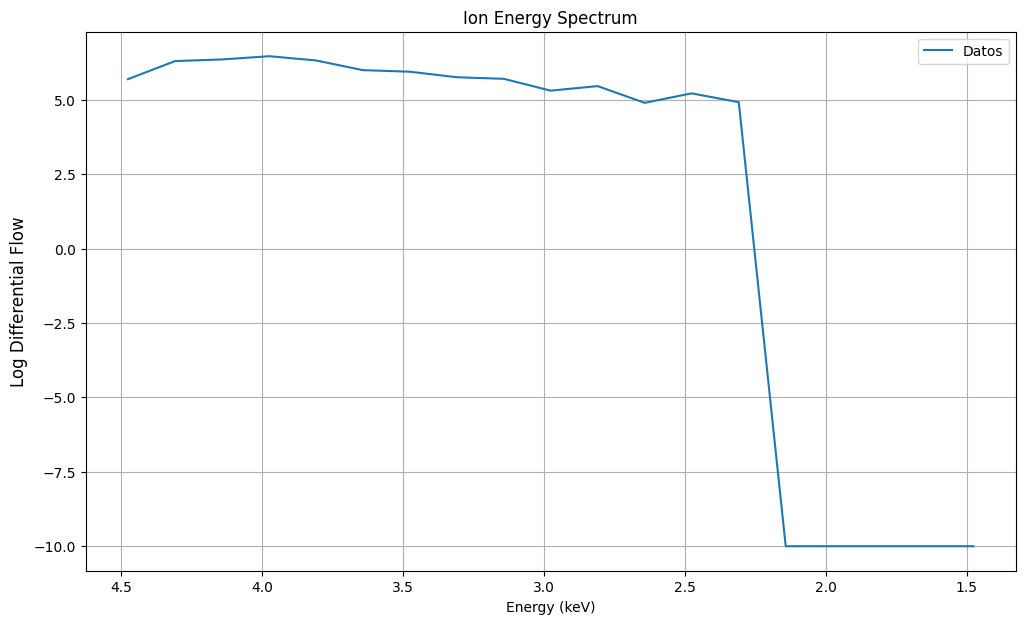

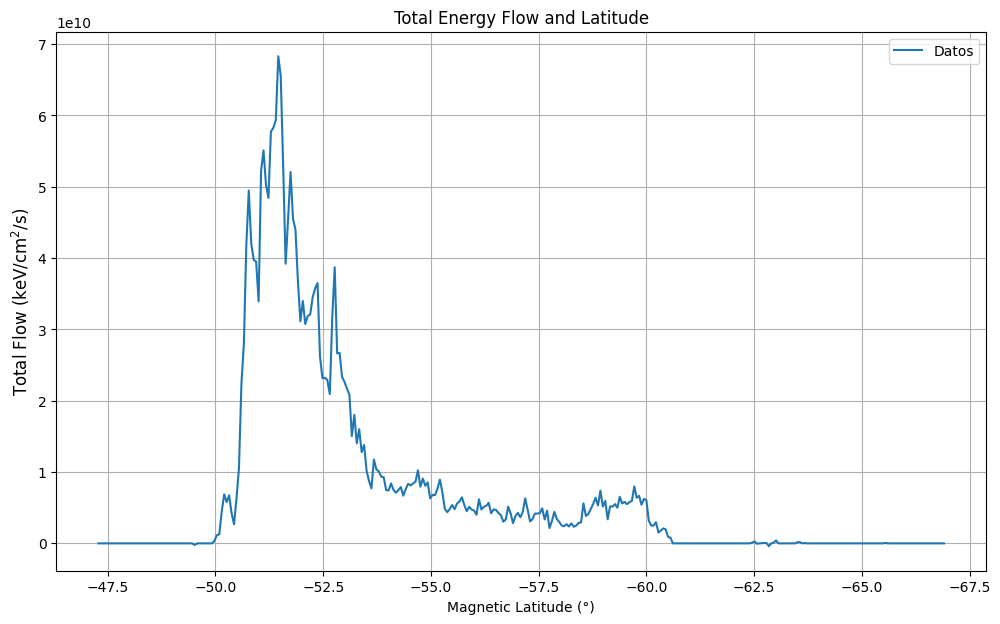

b2i se encuentra en la latitud magnética -51.457° y en el tiempo 2013-05-31T22:02:53.000000000


In [11]:
def cargar_datos(ruta_archivo):
    """
    Carga las variables necesarias desde un archivo CDF.

    Args:
        ruta_archivo (str): Ruta del archivo CDF.

    Returns:
        array: Latitudes magnéticas.
        array: Flujo total de energía.
        array: Energías.
        array: Flujo de energía diferencial.
        array: Tiempo.
    """
    try:
        cdf = cdflib.CDF(ruta_archivo)
        print(f"Archivo cargado: {ruta_archivo}")
        latitudes = cdf.varget('SC_GEOCENTRIC_LAT')
        flujo_total = cdf.varget('ION_TOTAL_ENERGY_FLUX')
        energias = cdf.varget('CHANNEL_ENERGIES')
        flujo_diferencial = cdf.varget('ION_DIFF_ENERGY_FLUX')
        tiempo = cdflib.cdfepoch.to_datetime(cdf.varget('Epoch'))
        return latitudes, flujo_total, energias, flujo_diferencial, tiempo
    except KeyError as e:
        print(f"Error: Variable no encontrada: {e}")
        return None, None, None, None, None

def logaritmizar_ajustado(array): #NECESITO VERIFICAR ESTA INFORMACIÓN
    """
    Aplica logaritmo base 10 sumando una constante pequeña a todos los datos.

    Args:
        array (array): Datos a logaritmizar.

    Returns:
        array: Datos logaritmizados.
    """
    epsilon = 1e-10
    return np.log10(array + epsilon)


def calculo_delta(energias): #HAY UNA FUNCIÓN QUE HACE EL PROCESO AUTOMÁTICO PERO NO CONCUERDA, USAR ESTA FUNCIÓN?
    """
    Calcula el ancho de las bandas energéticas.

    Args:
        energias (array): Energías.

    Returns:
        array: Ancho de las bandas energéticas.
    """
    delta = [(e2 - e1) / 2 for e1, e2 in zip(energias[1:], energias[:-1])]
    Left = energias[1] - energias[0]  # Extremo izquierdo.
    Rigth = energias[-1] - energias[-2]  # Extremo derecho.
    delta.insert(0, Left)
    delta.append(Rigth)
    return delta

def calculo_energia_total(flujos, delta, bandas):
    """
    Calcula el flujo total de energía para cada punto.

    Args:
        flujos (array): Flujo de energía diferencial.
        delta (array): Ancho de las bandas energéticas.
        bandas (int): Número de bandas energéticas consideradas.

    Returns:
        array: Flujo total de energía.
    """
    delta_recortado = np.array(delta[:bandas])  # Selecciona solo las primeras bandas
    return [sum(flujo[:bandas] * delta_recortado) for flujo in flujos]
    


def graficocolor(latitudes, energias, flujo, titulo, xlabel, ylabel, labelcolorbar):
    """
    Genera un gráfico de color.

    Args:
        latitudes (array): Latitudes magnéticas.
        energias (array): Energías.
        flujo (array): Flujo de energía.
        titulo (str): Título del gráfico.
        xlabel (str): Etiqueta del eje x.
        ylabel (str): Etiqueta del eje y.
        labelcolorbar (str): Etiqueta de la barra de color.
    """
    lat_edges = np.linspace(latitudes.min(), latitudes.max(), len(latitudes) + 1)
    energy_edges = np.linspace(energias.min(), energias.max(), len(energias) + 1)
    plt.figure(figsize=(12, 7))
    plt.pcolormesh(lat_edges, energy_edges, flujo, cmap="viridis", shading='auto')
    plt.colorbar(label=labelcolorbar)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel, fontsize = 12)
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

def graficar(x, y, titulo, xlabel, ylabel):
    """
    Genera un gráfico de línea.

    Args:
        x (array): Datos del eje x.
        y (array): Datos del eje y.
        titulo (str): Título del gráfico.
        xlabel (str): Etiqueta del eje x.
        ylabel (str): Etiqueta del eje y.
    """
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, label='Datos')
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel, fontsize = 12)
    plt.grid()
    plt.legend()
    plt.gca().invert_xaxis()
    plt.show()
    

def calcular_b2i(latitudes, flujo_total):
    """
    Identifica la latitud b2i como el máximo flujo total.

    Args:
        latitudes (array): Latitudes magnéticas.
        flujo_total (array): Flujo total de energía.

    Returns:
        float: Latitud b2i.
        int: Índice de la latitud b2i.
    """
    max_indice = np.argmax(flujo_total)
    b2i = latitudes[max_indice]
    return b2i, max_indice

def flujo_energetico_dms(filename, rango, espectro, bandas):
    """
    Proceso principal para calcular y graficar el flujo energético desde un archivo CDF.
    
    Args:
        filename (str): Ruta del archivo CDF.
        rango (tuple): Rango de índices a analizar (inicio, fin).
        espectro (int): Índice del espectro buscado.
        bandas (int): Número de bandas energéticas consideradas.
    """
    # Carga de datos
    latitudes, flujo_total, energias, flujo_diferencial, tiempo = cargar_datos(filename)
    if any(x is None for x in [latitudes, flujo_total, energias, flujo_diferencial, tiempo]):
        print("Error en la carga de datos. Revisa el archivo.")
        return

    N1, N2 = rango
    NS = espectro

    # Logaritmo de datos
    log_flujo_diferencial = logaritmizar_ajustado(flujo_diferencial)
    log_energias = logaritmizar_ajustado(energias)
    traspuesta_log_flujo = np.transpose(log_flujo_diferencial[N1:N2])

    # Gráfico de color: Flujo Diferencial
    graficocolor(
        latitudes[N1:N2], log_energias, traspuesta_log_flujo,
        "Differential Flow vs Latitude and Energy", "Magnetic Latitude (°)",
        "Energy (keV)", "Differential Flow (keV/cm$^2$/s/sr)"
    )

    # Gráfico de espectro: Energía de Iones
    graficar(
        log_energias, log_flujo_diferencial[NS],
        "Ion Energy Spectrum", "Energy (keV)", "Log Differential Flow"
    )

    # Cálculo de flujo total de energía
    delta = calculo_delta(energias)
    total_flujo = calculo_energia_total(flujo_diferencial[N1:N2], delta, bandas)

    # Gráfico de Flujo Total
    graficar(
        latitudes[N1:N2], total_flujo,
        "Total Energy Flow and Latitude", "Magnetic Latitude (°)", "Total Flow (keV/cm$^2$/s)"
    )

    # Calcular y mostrar b2i
    b2i, max_indice = calcular_b2i(latitudes[N1:N2], total_flujo)
    print(f"b2i se encuentra en la latitud magnética {b2i:.3f}° y en el tiempo {tiempo[N1:N2][max_indice]}")

# Parámetros y archivos en un diccionario, AQUI SE PUEDE AÑADIR MÁS ARCHIVOS, HAY UNA FORMA DE MEJORAR ESTO? Y SUPONGO QUE ESOS DATOS SON LOS QUE DEBO AUTOMATIZAR, NO?
archivos_datos = {#disponibilidad para añladir más elementos necesarios para el análisis
    "f16.1": {
        "archivo": "dmsp-f16_ssjs_precipitating-electrons-ions_20141231000000_20141231235959_cdaweb.cdf",
        "rango_datos": (79300, 79650),
        "espectro_datos": 79400,
        "bandas_energeticas": 6
    },
    "f16.2": {
        "archivo": "dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf",
        "rango_datos": (79300, 79650),
        "espectro_datos": 79400,
        "bandas_energeticas": 6
    }
}

# Iterar sobre el diccionario y aplicar la función principal
for nombre, parametros in archivos_datos.items():
    print(f"Procesando archivo: {nombre}")
    flujo_energetico_dms(
        parametros["archivo"],
        parametros["rango_datos"],
        parametros["espectro_datos"],
        parametros["bandas_energeticas"]
    )

